In [ ]:
import pandas as pd
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision import datasets
from collections import Counter
from utils import visualize_images, verify_image_sizes, plot_bar, create_conditioning_distribution, create_conditioning_vector, show_generated
from vae import VAE, train_vae
from gan import GAN, train_gan

In [2]:
basic_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,)*3, (0.5,)*3) ])
dataset = datasets.ImageFolder("data/trafic_32/trafic_32", transform=basic_transforms)

In [ ]:
analysis_loader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=14)
classes = dataset.classes
print("Class count:",len(classes))

Class count: 43


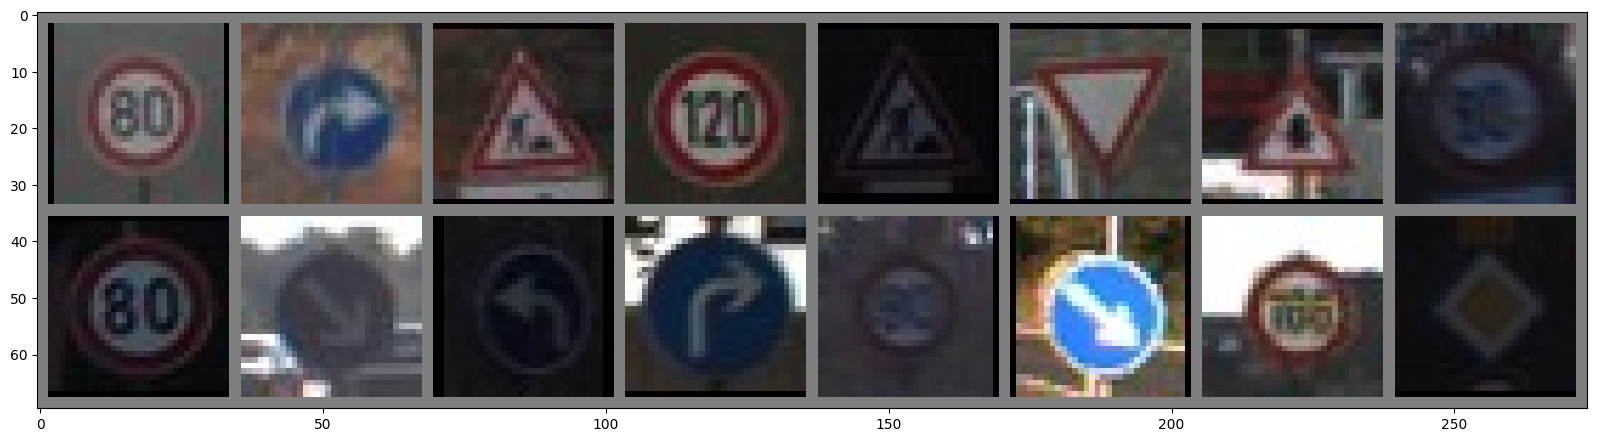

00005 00033 00025 00008 00025 00013 00011 00005 00005 00038 00034 00033 00005 00038 00007 00012


In [6]:
visualize_images(analysis_loader, classes, figsize=(20, 10))

In [7]:
verify_image_sizes(analysis_loader)

{torch.Size([3, 32, 32]): 39209}

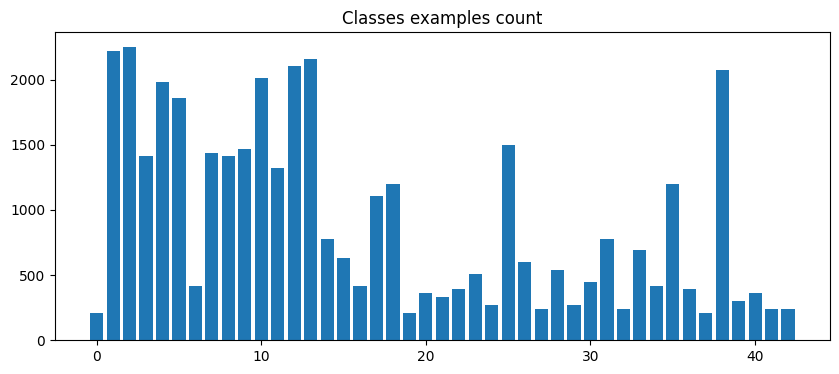

In [8]:
class_examples_num = dict(Counter(dataset.targets))
plot_bar(class_examples_num, "Classes examples count",  size=(10, 4))

In [3]:
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=14, pin_memory=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
vae = VAE(input_dim=3, hidden_dims=[32, 64, 128, 2048, 512], latent_dim=128, num_classes=43, label_emb_dim=32, device=device).to(device)

In [9]:
# train_vae(vae, device, train_dataloader, epochs=50, lr=1e-3)
vae.load("weights/vae.pth")

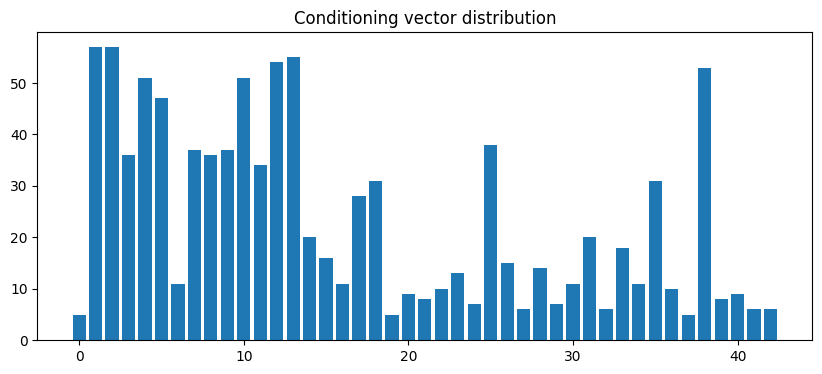

In [12]:
cond_distr = create_conditioning_distribution(dataset)
plot_bar(cond_distr , "Conditioning vector distribution",  size=(10, 4))

In [14]:
print(sum(cond_distr.values()))
conditioning_vector = create_conditioning_vector(cond_distr)

1000


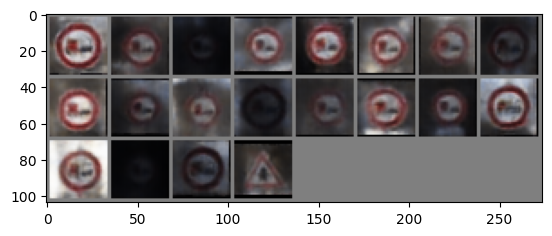

In [ ]:
generated_images = vae.generate(torch.Tensor(conditioning_vector).long().to(device))
show_generated(generated_images, 400, 420)


In [5]:
gan = GAN(input_dim=3*32*32, hidden_dims=[64, 128, 256, 512, 1024], latent_dim=128, num_classes=43, label_emb_dim=128, device=device, input_shape=(3, 32, 32), generator_batchnorm=True).to(device)


In [ ]:
train_gan(gan, device, train_dataloader, epochs=50, lr=2e-4)

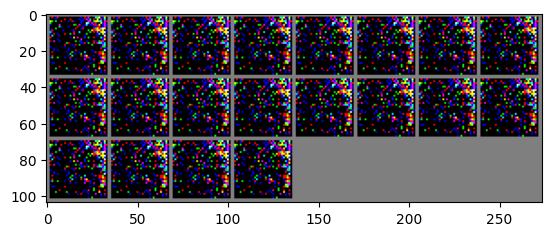

In [15]:
gan.load("weights/gan28.pth")
generated_images = gan.generate(torch.Tensor(conditioning_vector).long().to(device)).to("cpu")
show_generated(generated_images, 400, 420)